In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
num_qubits = 4
mini_qubits = 3
mini_qubits2 = 2
q_depth = 2
num_ancilla = 1

In [4]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=num_qubits+num_ancilla+10)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

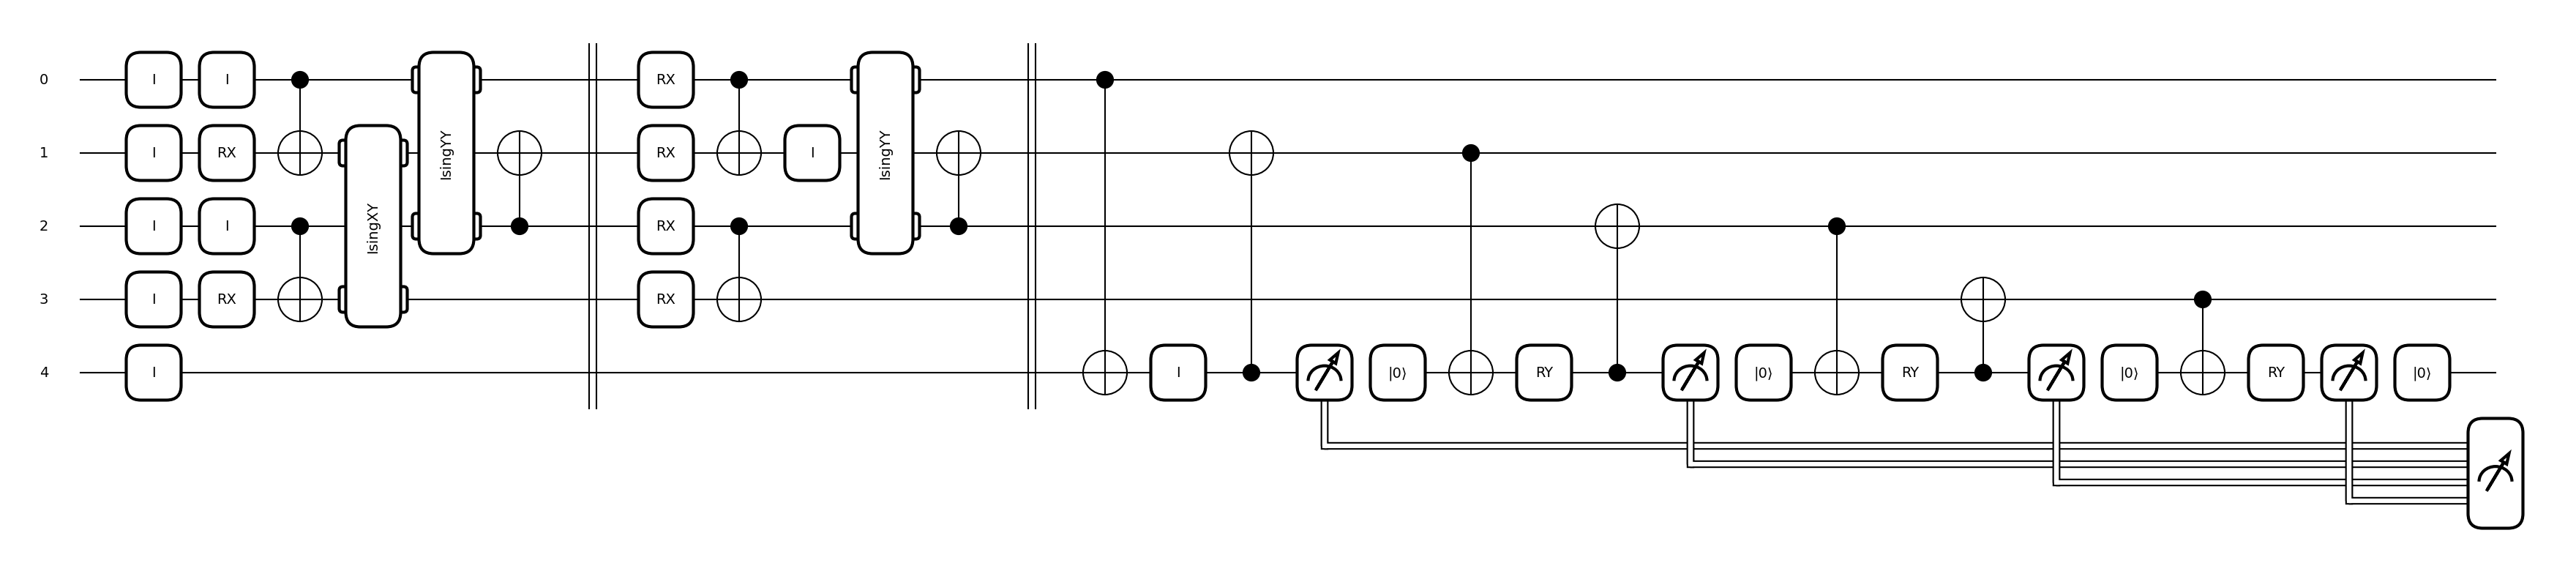

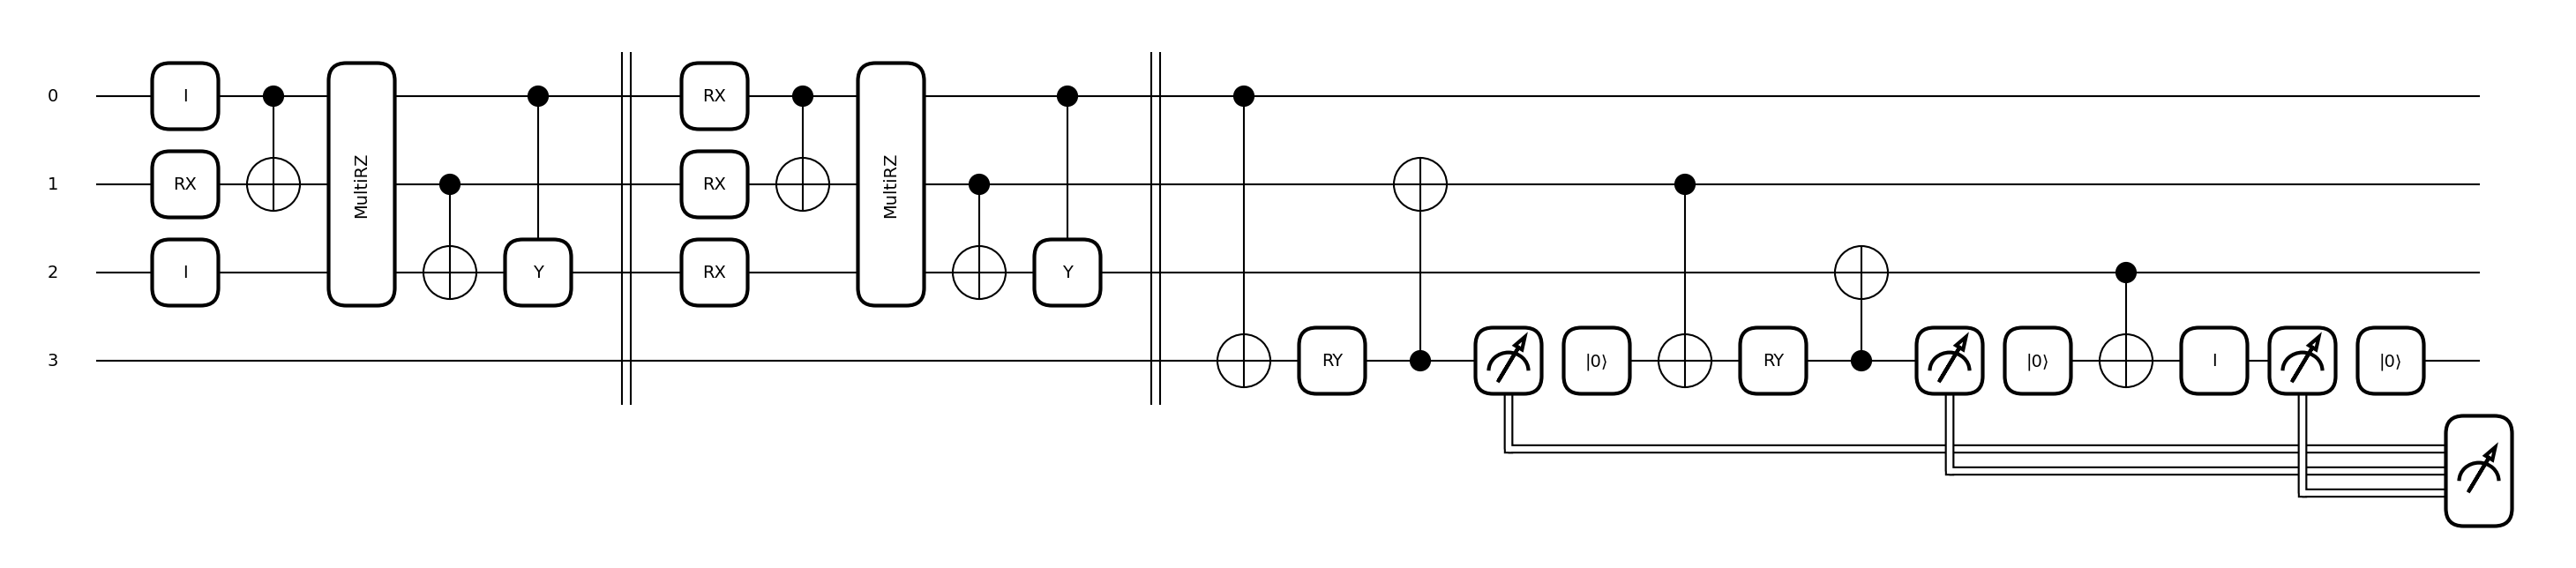

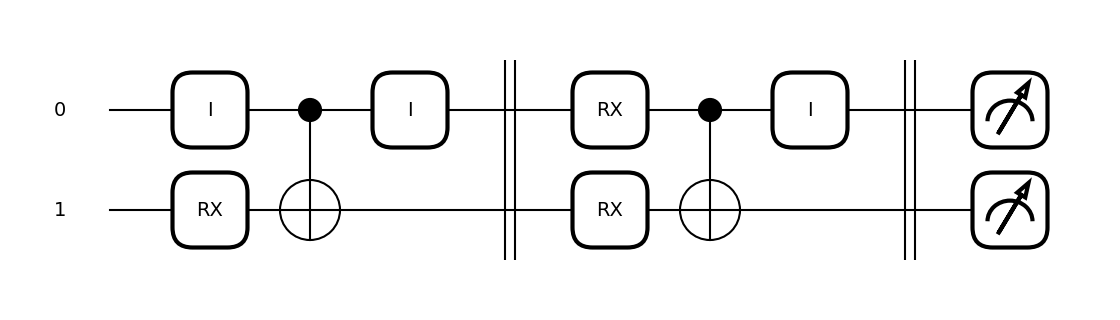

In [60]:
@qml.simplify
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, params):
    const = 6
    # Initialise latent vectors
    for i in range(num_qubits+num_ancilla):
        qml.RY(noise[i], wires=i)
    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(num_qubits):
            if num_qubits % 2 == 0:
                qml.RX(params[const*i+y], wires=y)
            else:
                qml.RZ(params[const*i + y], wires=y)
        qml.CNOT(wires = [0,1])
        qml.CNOT(wires = [2,3])
        # qml.CNOT(wires = [4,5])
        qml.IsingXY(params[const*i + 4], wires = [1, 3])
        qml.IsingYY(params[const*i + 5], wires = [0, 2])
        # qml.IsingZZ(params[const*i + 6], wires = [4, 5])
        # qml.CRX(params[const*i + 7], wires = [5, 2])
        qml.CNOT(wires = [2,1])
        qml.Barrier()

    measurements = []
    for i in range(num_qubits):
        qml.CNOT(wires = [i,num_qubits])
        qml.RY(params[const*q_depth+i], wires = 4)
        if i != num_qubits - 1:
            qml.CNOT(wires = [num_qubits, (i+1)])
        measurements.append(qml.measure(wires = 4, reset = True))
    # qml.Barrier()
    # for i in range(num_qubits):
    #     qml.CNOT(wires = [(i+2) % num_qubits,num_qubits+1])
    #     qml.RY(params[const*q_depth+i+1], wires = 5)
    #     if i != num_qubits - 1:
    #         qml.CNOT(wires = [num_qubits+1,(i + 2 +1)% num_qubits])
    #     measurements.append(qml.measure(wires = 5, reset = True))
    # qml.Toffoli(wires = [1,3,5])
    # qml.RY(params[const*q_depth + i], wires = 5)
    # qml.CNOT(wires = [5, 0])
    # qml.CNOT(wires = [5, 2])
    # measurements.append(qml.measure(wires = 5, reset = True))
    # qml.Toffoli(wires = [0,2,5])
    # qml.RY(params[const*q_depth + i], wires = 5)
    # measurements.append(qml.measure(wires = 5, reset = True))
        


    return [qml.probs(op = measurements[i]) for i in range(len(measurements))]

@qml.simplify
@qml.qnode(dev, diff_method="parameter-shift")
def mini_circuit(params):
    const = 4
    for i in range(q_depth):
        for j in range(mini_qubits):
            qml.RX(params[const*i + j], wires = j)
        qml.CNOT(wires = [0,1])
        qml.MultiRZ(params[mini_qubits], wires = [0,1,2])
        qml.CNOT(wires = [1,2])
        qml.CY(wires = [0,2])
        qml.Barrier()
    measurements = []
    for i in range(mini_qubits):
        qml.CNOT(wires = [i,mini_qubits])
        qml.RY(params[const*q_depth+i], wires = 3)
        if i != mini_qubits - 1:
            qml.CNOT(wires = [mini_qubits, i+1])
        measurements.append(qml.measure(wires = 3, reset = True))
    return [qml.probs(op = measurements[i]) for i in range(len(measurements))]

@qml.simplify
@qml.qnode(dev, diff_method="parameter-shift")
def mini_circuit2(params):
    const = 3
    for i in range(q_depth):
        for j in range(mini_qubits2):
            qml.RX(params[const*i+j], wires = j)
        for j in range(mini_qubits2-1):
            qml.CNOT(wires = [j, j+1])
        qml.IsingYY(params[mini_qubits2], wires = [0,1])
        qml.Barrier()
    return qml.probs(wires = list(range(mini_qubits2))) 

def quantum_process(noise, params, mini_layer, layer_num):
    probs = None
    if mini_layer:
        if layer_num == 1:
            probs = mini_circuit(params)
        elif layer_num == 2:
            probs = mini_circuit2(params)
    else:
        probs = quantum_circuit(noise, params)
    probs_tens = torch.Tensor()
    probs_tens.requires_grad = True
    if layer_num != 2:
        for i in range(len(probs)):
            probs_tens = torch.cat((probs_tens, torch.Tensor(probs[i])), dim = 0)
    else:
        probs_tens = probs.clone()
    probs_tens = torch.div(probs_tens.clone(), torch.sum(probs_tens.clone()))
    probs_tens = torch.div(probs_tens.clone(), torch.max(probs_tens.clone()))
    # tens.requires_grad = True
    return probs_tens

noise = [0,0,0,0,0,0]
weights = [0,1,0,1,2,3,1,2,1,2,0,1,0,1,2,3,1,2,1,2,4,4,4,4,4,4]

qml.draw_mpl(quantum_circuit)(noise,weights)
qml.draw_mpl(mini_circuit)(weights[:3*4])
qml.draw_mpl(mini_circuit2)(weights[:3*4])
plt.show()

In [91]:
class Autoencoder(nn.Module):
    def __init__(self, q_delta = 1, n_generators = 4):
        super().__init__()
        self.n_generators = n_generators
        self.q_depth = q_depth
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand((self.q_depth * 6 + 4) + (2 * 4 + 3) + (2 * 3)), requires_grad=True)
                for _ in range(self.n_generators)
            ]
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()
        )
    def forward(self, x):
        patch_size = 2**mini_qubits2
        images = torch.Tensor(x.size(0), 0).to(device)
        for params in self.q_params:
            
            patches = torch.Tensor(0, patch_size).to(device)
            # counter = 1
            # print(params.shape, elem.shape)
            # params[:16] = params.copy[:16]*elem[:counter * 16]
            # count+=1
            qlayer_probs = quantum_process([0,0,0,0,0], params, False, 0)
            mini_layer_params = qlayer_probs * params[(self.q_depth * 6 + 4):(self.q_depth * 6 + 4) + (2 * 4)]
            mini_layer_params = torch.cat((mini_layer_params,params[(self.q_depth * 6 + 4) + (2 * 4): (self.q_depth * 6 + 4) + (2 * 4+3)]))
            
            # mini_layer3_params = qlayer_probs[8:] * params[(self.q_depth * 6 + 12) + 8:]
            # mini_layer_params = torch.cat((params, mini_layer_params))
            mini_layer_probs = quantum_process([0,0,0,0,0], mini_layer_params, True, 1).float()
            mini_layer2_params = mini_layer_probs * params[(self.q_depth * 6 + 4) + (2 * 4 + 3):]
            q_out = quantum_process([0,0,0,0,0], mini_layer2_params, True, 2).float().unsqueeze(0)
            # q_out_three = quantum_process(elem, mini_layer3_params, True, 3).float()
            # q_out = torch.cat((q_out_one, q_out_two, q_out_three), dim = 0)
            # print(q_out_one, q_out_two, q_out_three)
            patches = torch.cat((patches, q_out))
            images = torch.cat((images, patches), 1)
            # print(images.shape)
        # images = images.view(x.size(0), 1, 8, 8)
        # print(images.shape)
        decoded = self.decoder(images)
        return decoded

In [92]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

In [93]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="optdigits.tra", label = 0, transform=transform)
print(dataset.__len__())
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

375


In [94]:

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
print(model.parameters)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

<bound method Module.parameters of Autoencoder(
  (q_params): ParameterList(
      (0): Parameter containing: [torch.float32 of size 33]
      (1): Parameter containing: [torch.float32 of size 33]
      (2): Parameter containing: [torch.float32 of size 33]
      (3): Parameter containing: [torch.float32 of size 33]
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Sigmoid()
  )
)>


In [95]:
results = []
quantum_losses = []

In [98]:
epochs = 20

for epoch in range(epochs):
    print(f'Starting Epoch {epoch+1}')
    print('----------------')
    loss = 0
    for i, (data, _) in enumerate(dataloader):
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        data = data.view(-1, 8*8).to(device)
        # print(data)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(data)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, data)
        # print(epoch, train_loss)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        results.append(outputs)
    # compute the epoch training loss
    loss = loss / dataloader.__len__()
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    quantum_losses.append(loss)

Starting Epoch 1
----------------
epoch : 1/20, loss = 0.049730
Starting Epoch 2
----------------
epoch : 2/20, loss = 0.024402
Starting Epoch 3
----------------
epoch : 3/20, loss = 0.024278
Starting Epoch 4
----------------
epoch : 4/20, loss = 0.024292
Starting Epoch 5
----------------
epoch : 5/20, loss = 0.024273
Starting Epoch 6
----------------
epoch : 6/20, loss = 0.024253
Starting Epoch 7
----------------
epoch : 7/20, loss = 0.024230
Starting Epoch 8
----------------
epoch : 8/20, loss = 0.024317
Starting Epoch 9
----------------


KeyboardInterrupt: 

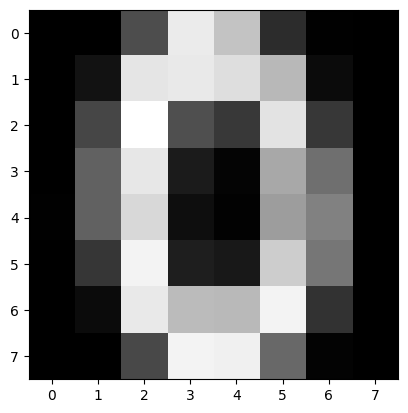

In [100]:
for j,item in enumerate(results[-1]):
    item = item.detach()
    item = item.reshape(-1,8,8)
    plt.imshow(item[0], cmap = 'gray')
    break